<a href="https://colab.research.google.com/github/InsupCode/ML_Interpretability/blob/main/Covid_Numerical_Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


In [2]:
!nvidia-smi

Wed Dec 11 18:59:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/content/df_cleaned_no2_mv_hosp.csv")

In [4]:
df.columns

Index(['SEX', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL'],
      dtype='object')

## Catboost classfier

### Data prep for Catboost classifier


In [5]:
# List of categorical columns
categorical_cols = ['SEX', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO']

In [6]:
X = df.drop(columns=['CLASIFFICATION_FINAL'])
y = df['CLASIFFICATION_FINAL']

In [7]:
#Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training

In [8]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [9]:
from catboost import CatBoostClassifier

In [11]:
cat_model = CatBoostClassifier(
    task_type='GPU',
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    cat_features=categorical_cols
)

In [12]:
cat_model.fit(X_train, y_train)

0:	learn: 0.6822196	total: 27.1ms	remaining: 27s
1:	learn: 0.6733506	total: 43.3ms	remaining: 21.6s
2:	learn: 0.6661672	total: 59.4ms	remaining: 19.8s
3:	learn: 0.6603149	total: 77.3ms	remaining: 19.2s
4:	learn: 0.6556616	total: 93.5ms	remaining: 18.6s
5:	learn: 0.6518396	total: 112ms	remaining: 18.6s
6:	learn: 0.6487508	total: 128ms	remaining: 18.2s
7:	learn: 0.6461580	total: 144ms	remaining: 17.9s
8:	learn: 0.6440781	total: 161ms	remaining: 17.7s
9:	learn: 0.6423727	total: 177ms	remaining: 17.6s
10:	learn: 0.6410159	total: 193ms	remaining: 17.4s
11:	learn: 0.6398805	total: 210ms	remaining: 17.3s
12:	learn: 0.6389976	total: 229ms	remaining: 17.4s
13:	learn: 0.6382038	total: 242ms	remaining: 17s
14:	learn: 0.6375293	total: 254ms	remaining: 16.7s
15:	learn: 0.6369807	total: 266ms	remaining: 16.3s
16:	learn: 0.6365232	total: 278ms	remaining: 16.1s
17:	learn: 0.6361215	total: 290ms	remaining: 15.8s
18:	learn: 0.6357948	total: 302ms	remaining: 15.6s
19:	learn: 0.6355203	total: 316ms	remain

In [13]:
y_pred1 = cat_model.predict(X_test)

Metrics

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred1):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred1))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.93      0.77    127162
           1       0.65      0.21      0.31     77869

    accuracy                           0.66    205031
   macro avg       0.65      0.57      0.54    205031
weighted avg       0.65      0.66      0.60    205031

Confusion Matrix:
[[118297   8865]
 [ 61725  16144]]


## Hyperparameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
catboost_model_ht = CatBoostClassifier(task_type="GPU", random_seed=42, verbose=0)

In [17]:
param_grid_catboost = {
    'iterations': [100, 200],          # Number of boosting iterations
    'depth': [3, 6, 10],                # Depth of trees
    'learning_rate': [0.01, 0.1],       # Learning rate
    'l2_leaf_reg': [1, 3, 5],           # Regularization parameter
    'border_count': [32, 64, 128]       # Number of splits for numeric features
}

In [18]:
grid_search_catboost = GridSearchCV(estimator=catboost_model_ht, param_grid=param_grid_catboost,
                                    cv=3, n_jobs=-1, scoring='accuracy')

In [19]:
grid_search_catboost.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7992b5d90910>,
             n_jobs=-1,
             param_grid={'border_count': [32, 64, 128], 'depth': [3, 6, 10],
                         'iterations': [100, 200], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.1]},
             scoring='accuracy')

In [20]:
print(f"Best Hyperparameters: {grid_search_catboost.best_params_}")

Best Hyperparameters: {'border_count': 64, 'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [21]:
best_cat_model = grid_search_catboost.best_estimator_

In [23]:
y_pred = best_cat_model.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.93      0.77    127162
           1       0.65      0.21      0.32     77869

    accuracy                           0.66    205031
   macro avg       0.65      0.57      0.54    205031
weighted avg       0.65      0.66      0.60    205031



In [25]:
y2 = best_cat_model.predict(X_test)

In [26]:
print(classification_report(y_test, y2))

              precision    recall  f1-score   support

           0       0.66      0.93      0.77    127162
           1       0.65      0.21      0.32     77869

    accuracy                           0.66    205031
   macro avg       0.65      0.57      0.54    205031
weighted avg       0.65      0.66      0.60    205031



In [27]:
#To save model:
# save the model as a pickle file
import pickle
model_pkl_file = "Catboost_HT_Covid_numeric_preprocessed.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(best_cat_model, file)

## Explanation Algorithms

In [19]:
X_test.head()

SEX  PNEUMONIA  AGE  DIABETES  COPD  ASTHMA  INMSUPR  HIPERTENSION  \
986952    1          2   37         2     2       2        2             2   
213358    2          2   64         1     2       2        2             1   
135655    1          2   35         2     2       2        2             2   
610607    2          2   55         2     2       2        2             2   
499321    2          2   34         2     2       2        2             2   

        OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  
986952              2               2        2              2        2  
213358              2               2        2              1        2  
135655              2               2        2              2        2  
610607              2               2        2              2        2  
499321              2               2        2              2        2

In [24]:
y_test.head(10)

986952    0
213358    0
135655    1
610607    1
499321    1
342391    1
322796    0
379761    0
160090    0
352182    1
Name: CLASIFFICATION_FINAL, dtype: int64

## Loading saved model

In [10]:
import pickle

In [12]:
 with open('/content/Catboost_HT_Covid_numeric_preprocessed.pkl', 'rb') as file:

       my_model = pickle.load(file)

### Using Lime for Explanation

In [13]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=efa330cd7f4c8a1ca112c5a5a27ace3c4c90748299f4bacee63d37f753de7665
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [14]:
import lime
import lime.lime_tabular
import numpy as np

In [15]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),feature_names=X_train.columns,verbose=True,mode='classification')

### Lime for a positive instance--(when a person is a carrier of covid)- Correct prediction by model

In [26]:
print(y_test.loc[352182])

1


In [25]:
instance_index = 352182
specific_instance = X_test.loc[instance_index]
# checking model's prediction
# Get the model's prediction for the instance
predicted_class = my_model.predict([specific_instance])
predicted_probabilities = my_model.predict_proba([specific_instance])
print(predicted_class)

[1]


In [28]:
exp = explainer.explain_instance(X_test.loc[352182],my_model.predict_proba)

exp.show_in_notebook(show_table=True)

Intercept 0.40283659750521617
Prediction_local [0.45359329]
Right: 0.6480791796550722


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

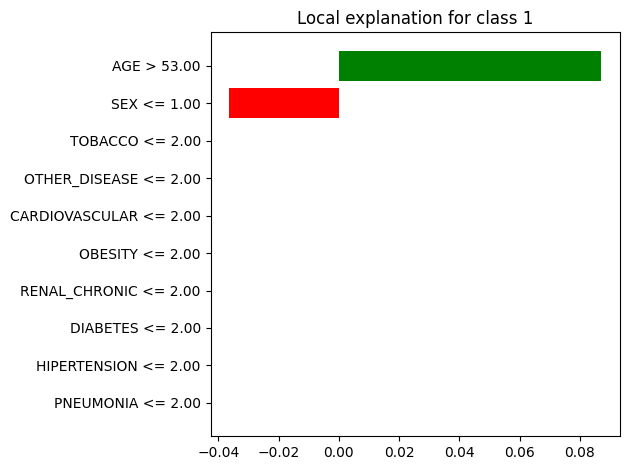

In [29]:
import matplotlib.pyplot as plt

exp.as_pyplot_figure()
plt.tight_layout()

## Lime for a negative instance-- When a person is not a carrier of covid--Correct prediction by model

In [30]:
print(y_test.loc[213358])

0


In [32]:
instance_index = 213358
specific_instance = X_test.loc[instance_index]
# checking model's prediction
# Get the model's prediction for the instance
predicted_class = my_model.predict([specific_instance])
predicted_probabilities = my_model.predict_proba([specific_instance])
print(predicted_class)

[0]


In [34]:
exp = explainer.explain_instance(X_test.loc[213358],my_model.predict_proba)

exp.show_in_notebook(show_table=True)

Intercept 0.37132901865537493
Prediction_local [0.49123502]
Right: 0.4289778272581232


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

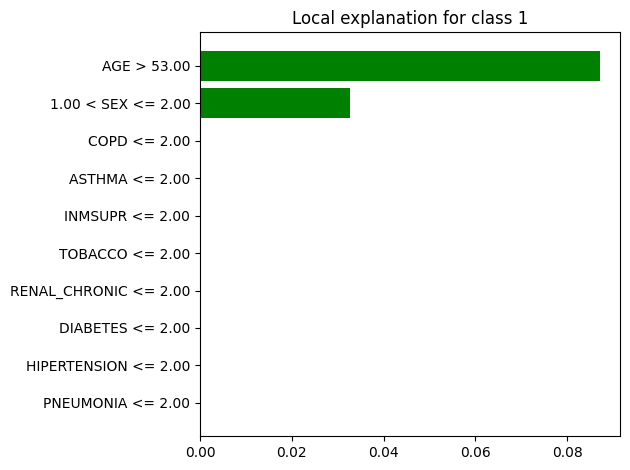

In [35]:
import matplotlib.pyplot as plt

exp.as_pyplot_figure()
plt.tight_layout()

### Incorrect prediciton by model

In [36]:
print(y_test.loc[135655])

1


In [37]:
instance_index = 135655
specific_instance = X_test.loc[instance_index]
# checking model's prediction
# Get the model's prediction for the instance
predicted_class = my_model.predict([specific_instance])
predicted_probabilities = my_model.predict_proba([specific_instance])
print(predicted_class)

[0]


In [39]:
exp = explainer.explain_instance(X_test.loc[135655],my_model.predict_proba)

exp.show_in_notebook(show_table=True)

Intercept 0.42468817855352525
Prediction_local [0.38926562]
Right: 0.3123846564071764


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

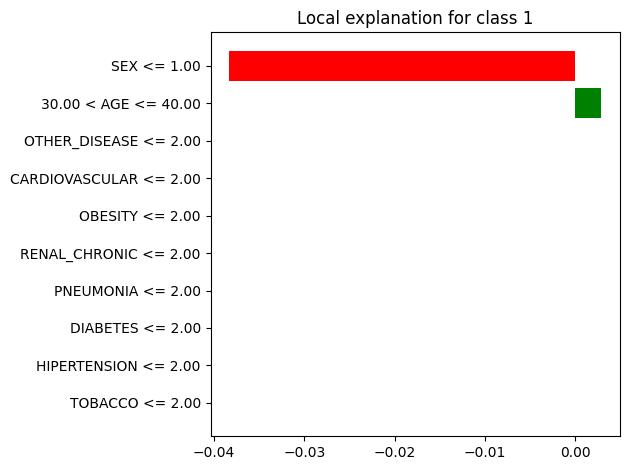

In [40]:
import matplotlib.pyplot as plt

exp.as_pyplot_figure()
plt.tight_layout()

## Using SHAP for explanations

In [41]:
!pip install catboost shap

In [42]:
import shap

In [43]:
explainer = shap.TreeExplainer(my_model)

In [44]:
shap_values = explainer.shap_values(X_test)

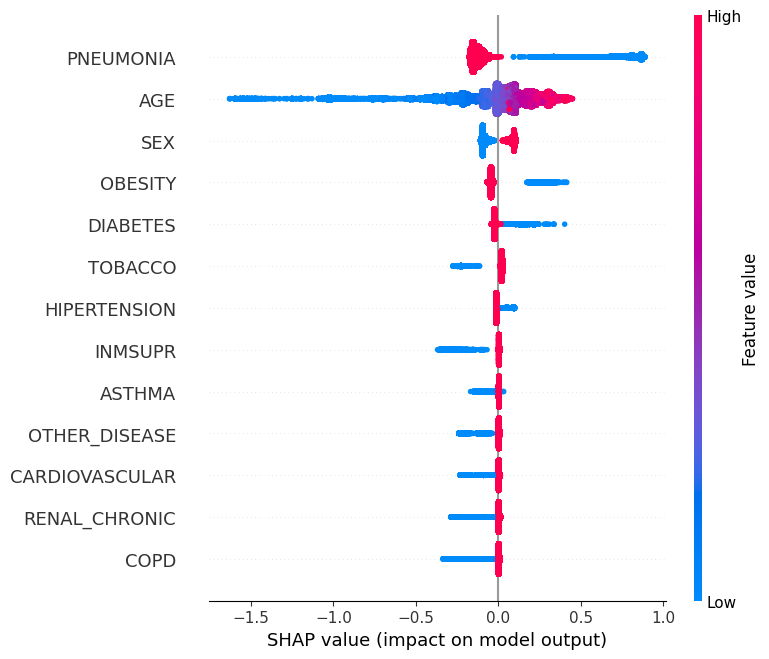

In [45]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

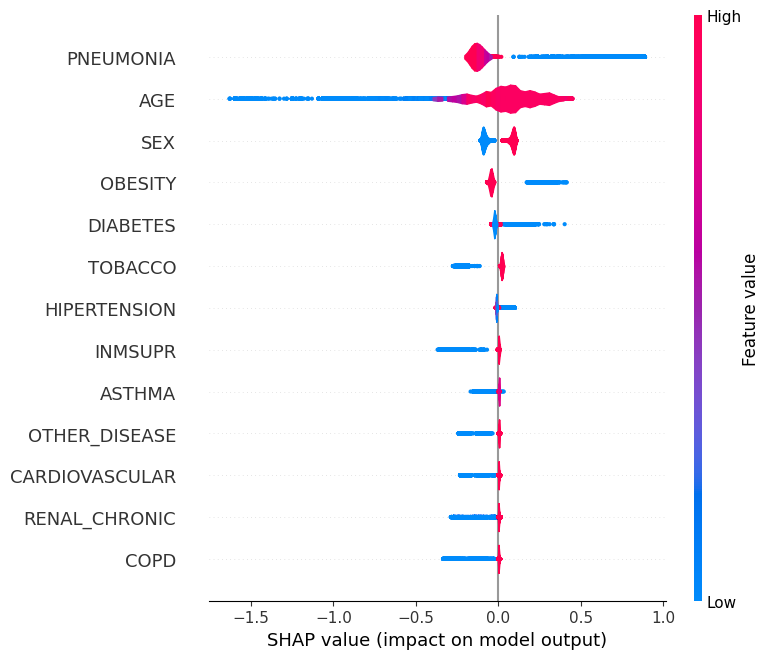

In [46]:
#Same as above, but with violin plots to better see the distribution of shapley values
shap.summary_plot(shap_values, X_test, plot_type="violin")

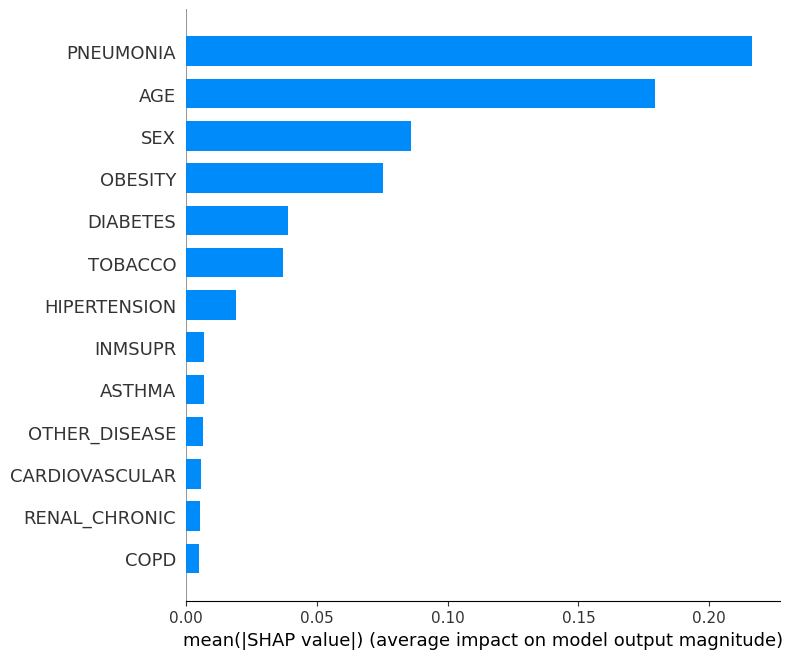

In [47]:
shap_values = explainer.shap_values(X_test)

# bar plot for feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

### For a particular instance

In [48]:
X_test.loc[0]

SEX                1
PNEUMONIA          1
AGE               65
DIABETES           2
COPD               2
ASTHMA             2
INMSUPR            2
HIPERTENSION       1
OTHER_DISEASE      2
CARDIOVASCULAR     2
OBESITY            2
RENAL_CHRONIC      2
TOBACCO            2
Name: 0, dtype: int64

In [49]:
y_test[0]

1

In [50]:
index = 0
instance = X_test.iloc[[index]]

# Generate the SHAP values for the instance
shap_value_instance = explainer.shap_values(instance)[0]

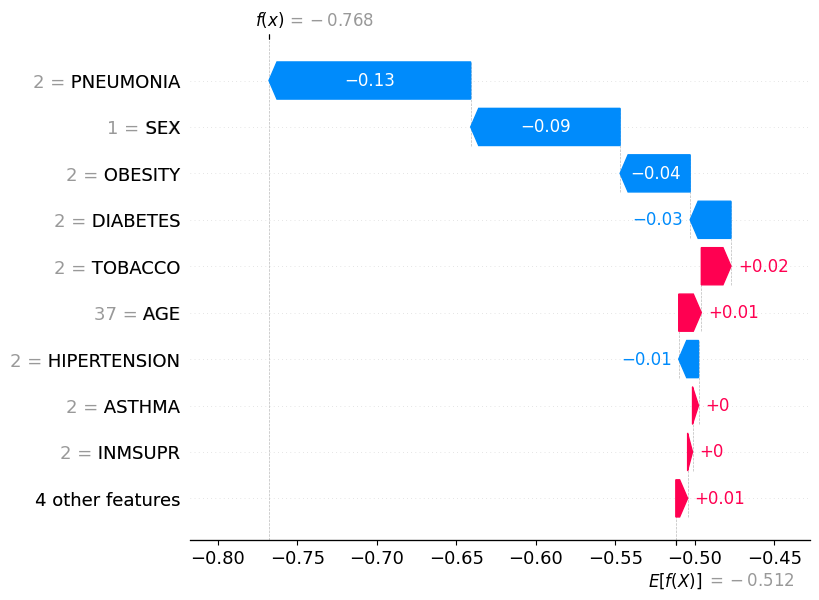

In [51]:
# Plot a waterfall chart
shap.waterfall_plot(shap.Explanation(values=shap_value_instance,
                                     base_values=explainer.expected_value,
                                     data=instance.iloc[0]))

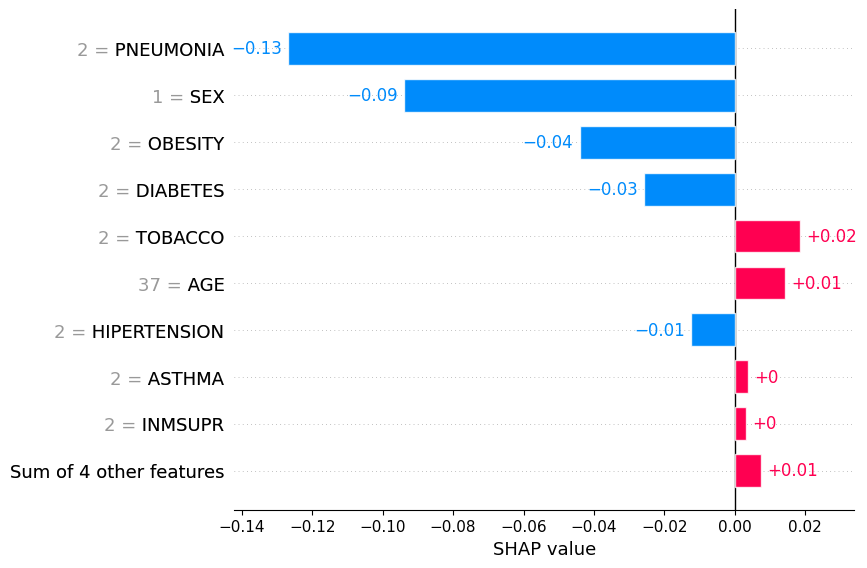

In [52]:
#bar plot for same instance
shap.plots.bar(shap.Explanation(values=shap_value_instance,
                                base_values=explainer.expected_value,
                                data=instance.iloc[0]))